In [1]:
CODE_ROOT = pwd() * "/"

include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")
include(CODE_ROOT * "visualization.jl")
include(CODE_ROOT * "mode_init/exactsolutions.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean_CUDA.jl")

include(CODE_ROOT * "mode_forward/calculate_tendencies_cuda.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean_CUDA.jl")

MPAS_Ocean_CUDA

In [2]:
using BenchmarkTools
using DelimitedFiles
using Dates

In [3]:
function kelvinWaveCUDAGenerator(mpasOcean, lateralProfile)
    meanCoriolisParameterf = sum(mpasOcean.fEdge) / length(mpasOcean.fEdge)
    meanFluidThicknessH = sum(mpasOcean.bottomDepth)/length(mpasOcean.bottomDepth)
    c = sqrt(mpasOcean.gravity*meanFluidThicknessH)
    rossbyRadiusR = c/meanCoriolisParameterf
    
    
    function boundaryConditionCUDA_kernel!(nEdges, normalVelocityCurrent, maxLevelEdgeTop, boundaryEdge, angleEdge, yEdge, xEdge, t)
        iEdge = (CUDA.blockIdx().x - 1) * CUDA.blockDim().x + CUDA.threadIdx().x
        if iEdge <= nEdges
            if boundaryEdge[iEdge] == 1
                for k in 1:maxLevelEdgeTop[iEdge]
                    normalVelocityCurrent[k,iEdge] = CUDA.sin(angleEdge[iEdge]) * c * lateralProfile(yEdge[iEdge] + c*t) * CUDA.exp(-xEdge[iEdge]/rossbyRadiusR)
                end
            end
        end
        return nothing
    end
    function boundaryConditionCUDA!(mpasOcean::MPAS_Ocean_CUDA, t::Float64)
        CUDA.@cuda blocks=cld(mpasOcean.nEdges, 1024) threads=1024 maxregs=64 boundaryConditionCUDA_kernel!(mpasOcean.nEdges,
                                                                                        mpasOcean.normalVelocityCurrent,
                                                                                        mpasOcean.maxLevelEdgeTop,
                                                                                        mpasOcean.boundaryEdge,
                                                                                        mpasOcean.angleEdge,
                                                                                        mpasOcean.yEdge,
                                                                                        mpasOcean.xEdge,
                                                                                        t)
        return nothing
    end

    return boundaryConditionCUDA!
end

kelvinWaveCUDAGenerator (generic function with 1 method)

In [56]:
function gpuperftest(nCellsX, nSamples=10, nCycles=10, showplots=false, writedata=false, problem="inertiagravitywave"; mesh_dir=CODE_ROOT * "MPAS_O_Shallow_Water/ConvergenceStudyMeshes/InertiaGravityWave/", nvlevels=100)
    fpath = CODE_ROOT * "output/$(problem)/$(CUDA.name(CUDA.device()))/resolution$(nCellsX)x$(nCellsX)/steps$(nCycles)/nvlevels$(nvlevels)/"
    fname = "$fpath$(Dates.now()).txt"
    if writedata
        mkpath(fpath)
        println("output file: $fname")
    end
    
    
    # load mesh from file and set up initial condition
    exacttime = 0.0
    if problem == "kelvinwave"
        mpasMesh = MPAS_Ocean(mesh_dir,
            "culled_mesh_$(nCellsX)x$(nCellsX).nc", "mesh_$(nCellsX)x$(nCellsX).nc", periodicity="NonPeriodic_x", nvlevels=nvlevels)

        @inline function lateralProfile(y)
            return 1e-3 * exp( - (y-3e6)^2 / 5e5^2 )
        end

        kelvinWaveExactNormalVelocity, kelvinWaveExactSSH, kelvinWaveExactSolution!, device_boundary_condition! = kelvinWaveGenerator(mpasMesh, lateralProfile)

        kelvinWaveExactSolution!(mpasMesh, exacttime)
        
        boundarycondition_cuda! = kelvinWaveCUDAGenerator(mpasMesh, lateralProfile)
        
    elseif problem == "inertiagravitywave"
        mpasMesh = MPAS_Ocean(mesh_dir,
        "base_mesh_$(nCellsX)x$(nCellsX).nc", "mesh_$(nCellsX)x$(nCellsX).nc", periodicity="NonPeriodic_x", nvlevels=nvlevels)

        etaHat, f0, kX, kY, omega = inertiaGravityWaveParams(mpasMesh, 1, 4, 1e-3)
        inertiaGravityExactSolution!(mpasMesh, etaHat, f0, kX, kY, omega, exacttime)

        boundarycondition_cuda!(mpasOcean, time) = nothing;
    end
    
    if showplots
        fig, ax, _ = heatMapMesh(mpasMesh, -mpasMesh.bottomDepth + dropdims(sum(mpasMesh.layerThickness, dims=1), dims=1))
        ax.set_title("Initial Sea Surface Height")
        display(fig)
    end
    
    mpasOcean = MPAS_Ocean_CUDA(mpasMesh)
    
    # if "GPU" == device
    # mpasOcean = MPAS_Ocean_CUDA(mpasOcean)
    # device_boundary_condition! = kelvinWaveCUDAGenerator(mpasOcean, lateralProfile)
#     device_step_nv! = function(mpasOcean)
        
#     end
#     device_step_ssh! = function(mpasOcean)
        
#     end
    # end
    
    sampletimes = zeros(Float64, nSamples)
    sampletimesbus = zeros(Float64, nSamples)
    
    ###### >>>>>>>>>> var test
        # make struct data into variables
        global nEdges, normalVelocityTendency, normalVelocityCurrent, layerThickness, maxLevelEdgeTop, cellsOnEdge, nEdgesOnEdge, edgesOnEdge, weightsOnEdge, fEdge, dcEdge, gravity, dt, nCells, nEdgesOnCell, edgesOnCell, cellsOnCell, areaCell, edgeSignOnCell, dvEdge, maxLevelCell, layerThicknessTendency, layerThickness = mpasOcean.nEdges, mpasOcean.normalVelocityTendency, mpasOcean.normalVelocityCurrent, mpasOcean.layerThickness, mpasOcean.maxLevelEdgeTop, mpasOcean.cellsOnEdge, mpasOcean.nEdgesOnEdge, mpasOcean.edgesOnEdge, mpasOcean.weightsOnEdge, mpasOcean.fEdge, mpasOcean.dcEdge, mpasOcean.gravity, mpasOcean.dt, mpasOcean.nCells, mpasOcean.nEdgesOnCell, mpasOcean.edgesOnCell, mpasOcean.cellsOnCell, mpasOcean.areaCell, mpasOcean.edgeSignOnCell, mpasOcean.dvEdge, mpasOcean.maxLevelCell, mpasOcean.layerThicknessTendency, mpasOcean.layerThickness
    
        # make kernels implementing the variables rather than performing lookup on struct
        function calc_nv_tend_cuda()
            global nEdges, normalVelocityTendency, normalVelocityCurrent, layerThickness, maxLevelEdgeTop, cellsOnEdge, nEdgesOnEdge, edgesOnEdge, weightsOnEdge, fEdge, dcEdge, gravity
            CUDA.@cuda blocks=cld(nEdges, 1024) threads=1024 maxregs=64 calculate_normal_velocity_tendency_cuda_kernel!(
                                                                                    nEdges,
                                                                                    normalVelocityTendency,
                                                                                    normalVelocityCurrent,
                                                                                    layerThickness,
                                                                                    maxLevelEdgeTop,
                                                                                    cellsOnEdge,
                                                                                    nEdgesOnEdge,
                                                                                    edgesOnEdge,
                                                                                    weightsOnEdge,
                                                                                    fEdge,
                                                                                    dcEdge,
                                                                                    gravity)
        end


        function update_nv_cuda()
            global nEdges, normalVelocityCurrent, dt, normalVelocityTendency, maxLevelEdgeTop
            CUDA.@cuda blocks=cld(nEdges, 1024) threads=1024 maxregs=64 update_normal_velocity_by_tendency_cuda_kernel!(
                                                                                    nEdges,
                                                                                    normalVelocityCurrent,
                                                                                    dt,
                                                                                    normalVelocityTendency,
                                                                                    maxLevelEdgeTop)
        end



        function calc_thick_tend_cuda()
            global nCells, layerThicknessTendency, layerThickness, normalVelocityCurrent, maxLevelEdgeTop, nEdgesOnCell, edgesOnCell, cellsOnCell, areaCell, edgeSignOnCell, dvEdge, maxLevelCell
            CUDA.@cuda blocks=cld(nCells, 1024) threads=1024 maxregs=64 calculate_thickness_tendency_cuda_kernel!(
                                                                                    nCells,
                                                                                    layerThicknessTendency,
                                                                                    layerThickness,
                                                                                    normalVelocityCurrent,
                                                                                    maxLevelEdgeTop,
                                                                                    nEdgesOnCell,
                                                                                    edgesOnCell,
                                                                                    cellsOnCell,
                                                                                    areaCell,
                                                                                    edgeSignOnCell,
                                                                                    dvEdge,
                                                                                    maxLevelCell)
        end

        function update_thick_cuda()
            global nCells, layerThickness, dt, layerThicknessTendency, maxLevelCell
            CUDA.@cuda blocks=cld(nCells, 1024) threads=1024 maxregs=64 update_thickness_by_tendency_cuda_kernel!(
                                                                                    nCells,
                                                                                    layerThickness,
                                                                                    dt,
                                                                                    layerThicknessTendency,
                                                                                    maxLevelCell)
        end
    ############### <<< var test

    
    
    for s in 1:nSamples
        sampletimes[s] += CUDA.@elapsed begin for j in 1:nCycles
                calc_nv_tend_cuda()
                update_nv_cuda()
                calc_thick_tend_cuda()
                update_thick_cuda()
                # calculate_normal_velocity_tendency_cuda!(mpasOcean)
                # update_normal_velocity_by_tendency_cuda!(mpasOcean)
                # boundarycondition_cuda!(mpasOcean, exacttime+mpasMesh.dt)
                # calculate_thickness_tendency_cuda!(mpasOcean)
                # update_thickness_by_tendency_cuda!(mpasOcean)
                # exacttime += mpasMesh.dt
            end
        end
        sampletimesbus[s] = @elapsed begin
            thicknesscpu = Array(layerThickness[:,:])
            normvelcpu = Array(normalVelocityCurrent[:,:])
        end
    end
    
    
    println("calculating exact solution")
    exactSSH = zeros(Float64, mpasOcean.nCells)
    if problem == "inertiagravitywave"
        for iCell in 1:mpasOcean.nCells
            exactSSH[iCell] = DetermineInertiaGravityWaveExactSurfaceElevation(etaHat,kX,kY,omega,mpasMesh.xCell[iCell],mpasMesh.yCell[iCell],exacttime)
        end
    elseif problem == "kelvinwave"
        for iCell in 1:mpasOcean.nCells
            exactSSH[iCell] = kelvinWaveExactSSH(mpasMesh, iCell, exacttime)
        end
    end
    
    # calculate error between exact solution and numerical
    numSSH = dropdims(sum(Array(mpasOcean.layerThickness), dims=1), dims=1) .- Array(mpasOcean.bottomDepth)
    error =  sum( ( numSSH .- exactSSH ) .^ 2 )
    
    if showplots
        fig, ax, _ = heatMapMesh(mpasMesh, numSSH)
        ax.set_title("Final Numerical Sea Surface Height")
        display(fig)
        
        fig, ax, _ = heatMapMesh(mpasMesh, exactSSH)
        ax.set_title("Final Exact Sea Surface Height")
        display(fig)
        
        fig, ax, _ = edgeHeatMapMesh(mpasMesh, sum(Array(mpasOcean.normalVelocityTendency), dims=1))
        ax.set_title("final numerical NV tendnecy (sum over all layers)")
        display(fig)
    end
    
    if writedata
        open(fname, "w") do io
            writedlm(io, [sampletimes, sampletimesbus])
        end
    end
    
    return sampletimes, sampletimesbus, error, mpasOcean, mpasMesh
end

gpuperftest (generic function with 6 methods)

# Try the GPU performance test

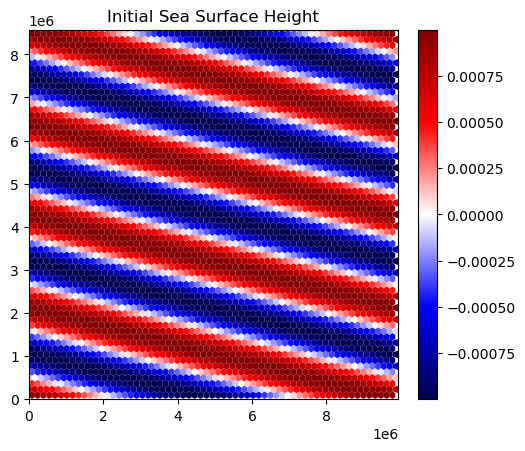

calculating exact solution


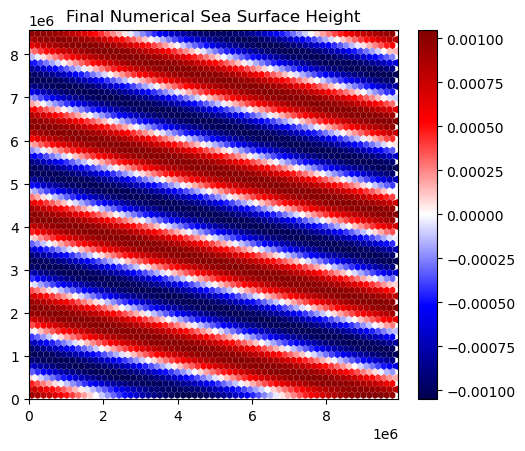

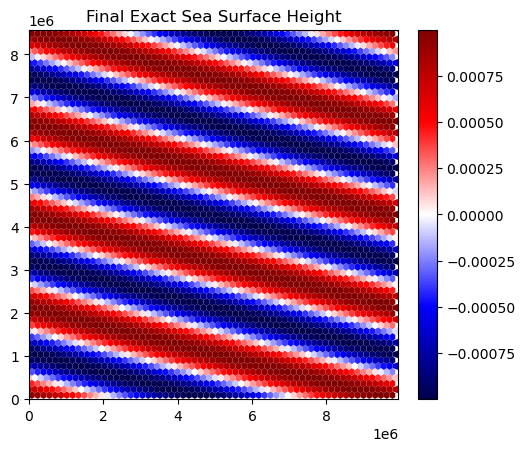

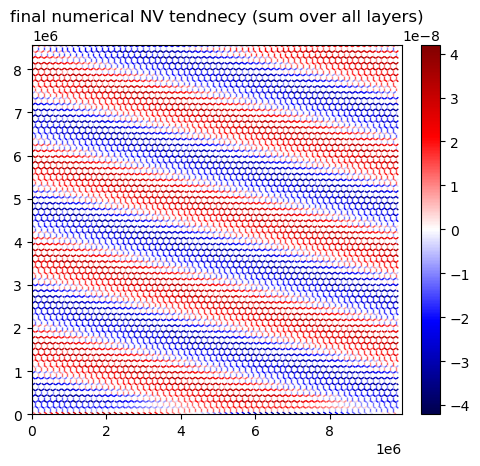

execution time: [0.15742236375808716, 0.08060210943222046, 0.07301334291696548, 0.07299545407295227, 0.07302301377058029, 0.0729919970035553, 0.07302208244800568, 0.07299033552408218, 0.07301343977451324, 0.07300665229558945]
bus to cpu time: [0.001155955, 0.001273963, 0.001098754, 0.001084538, 0.001205712, 0.001080901, 0.001098995, 0.002519362, 0.00108084, 0.001202085]
L2 error from exact sol: 2.633980442472033e-6


In [57]:
nCellsX = 64
wcgpu, wcbus, errgpu, mpasOceanCuda, mpasMesh = gpuperftest(nCellsX, 10, 10, true, false, nvlevels=100)
println("execution time: $wcgpu")
println("bus to cpu time: $wcbus")
println("L2 error from exact sol: $errgpu")

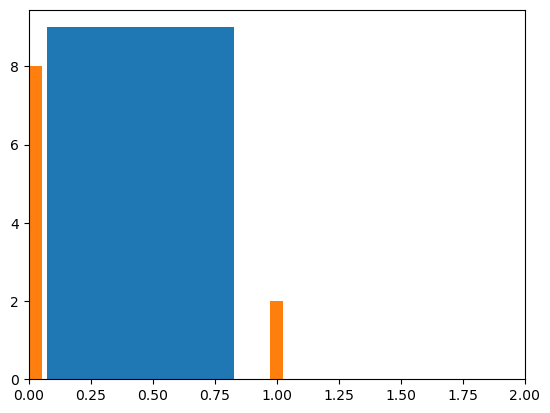

(0.0, 2.0)

In [15]:
plt.hist(wcgpu, bins=20)
plt.hist(wcbus, bins=20)

# run it on the desired meshes

In [21]:
for nCellsX in [16, 32, 64, 128, 256, 512]
    println("\n\t nCellsX: $(nCellsX)\n")
    wcgpu, wcbus, errgpu, mpasOceanCuda, mpasMesh = gpuperftest(nCellsX, 10, 10, false, true, nvlevels=100,
                            mesh_dir=CODE_ROOT * "MPAS_O_Shallow_Water/ConvergenceStudyMeshes/InertiaGravityWave/")
    println("execution time: $wcgpu")
    println("bus to cpu time: $wcbus")
    println("L2 error from exact sol: $errgpu")
end

nCellsX: 16
output file: /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/inertiagravitywave/NVIDIA A100-SXM4-40GB/resolution16x16/steps10/nvlevels100/2023-06-05T15:12:41.511.txt
calculating exact solution
	 execution time: [0.037573982030153275, 0.03752991929650307, 0.03754684701561928, 0.03753634914755821, 0.037560511380434036, 0.036788031458854675, 0.0291458573192358, 0.029149599373340607, 0.029158880934119225, 0.029199328273534775]
	 bus to cpu time: [0.000162254, 0.000136905, 0.0001348, 0.000142917, 0.000133238, 0.000136113, 0.000131936, 0.000123909, 0.000124952, 0.000128018]
	 L2 error from exact sol: 0.00021011831714691257
nCellsX: 32
output file: /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/inertiagravitywave/NVIDIA A100-SXM4-40GB/resolution32x32/steps10/nvlevels100/2023-06-05T15:12:41.870.txt
calculating exact solution
	 execution time: [0.06713846325874329, 0.06701318174600601, 0.06704559922218323, 0.06699919700622559, 0.06704140454530716, 0.06706531345844269, 0.066

In [53]:
nCellsX = 64
nvlevels = 100
exacttime = 0.0
nCycles = 10
nSamples = 10
mesh_dir = CODE_ROOT * "MPAS_O_Shallow_Water/ConvergenceStudyMeshes/InertiaGravityWave/"

mpasMesh = MPAS_Ocean(mesh_dir,
"base_mesh_$(nCellsX)x$(nCellsX).nc", "mesh_$(nCellsX)x$(nCellsX).nc", periodicity="NonPeriodic_x", nvlevels=nvlevels)

etaHat, f0, kX, kY, omega = inertiaGravityWaveParams(mpasMesh, 1, 4, 1e-3)
inertiaGravityExactSolution!(mpasMesh, etaHat, f0, kX, kY, omega, exacttime)

boundarycondition_cuda!(mpasOcean, time) = nothing;

In [ ]:
using NVTX

CUDA.@profile begin

    mpasOcean = MPAS_Ocean_CUDA(mpasMesh)

    # sampletimes = zeros(Float64, nSamples)
    # sampletimesbus = zeros(Float64, nSamples)

    for s in 1:nSamples
        # sampletimes[s] += 
        for j in 1:nCycles
            NVTX.@range "stepping NV" begin 
                calculate_normal_velocity_tendency_cuda!(mpasOcean)
                update_normal_velocity_by_tendency_cuda!(mpasOcean)
            end
            NVTX.@range "stepping thickness" begin
                # boundarycondition_cuda!(mpasOcean, exacttime+mpasMesh.dt)
                calculate_thickness_tendency_cuda!(mpasOcean)
                update_thickness_by_tendency_cuda!(mpasOcean)
                # exacttime += mpasMesh.dt
            end
            #end
            NVTX.@mark "$(j)th step"
        end

        NVTX.@range "bussing to cpu" begin
            thicknesscpu = Array(mpasOcean.layerThickness[:,:])
            normvelcpu = Array(mpasOcean.normalVelocityCurrent[:,:])
        end
    end

end


In [8]:
mpasMesh.dcEdge

12288-element Vector{Float64}:
 156249.99999999965
 156250.0
 156249.99999999965
 156250.00000000006
 156250.0
 156249.99999999965
 156249.99999999965
 156250.00000000006
 156250.0
 156250.0
 156250.00000000006
 156250.0
 156250.00000000006
      ⋮
 156250.00000000006
 156250.0
 156249.99999999965
 156249.99999999965
 156250.00000000006
 156250.00000000006
 156250.00000000047
 156249.99999999965
 156250.0
 156250.0
 156249.99999999965
 156249.99999999884

In [ ]:
nCellsX = 256
wc, err, mpasOceanCuda = gpuperftest(nCellsX, 2, 10, true, false)
mpasOcean = MPAS_Ocean(CODE_ROOT * "MPAS_O_Shallow_Water/ConvergenceStudyMeshes/InertiaGravityWave",
        "base_mesh_$(nCellsX)x$(nCellsX).nc", "mesh_$(nCellsX)x$(nCellsX).nc", periodicity="Periodic", nvlevels=100)
;

In [5]:
for nCellsX in [128, 256, 512]
    wc, err = gpuperftest(nCellsX, 2, 10, true, true)
    println("wallclock $wc")
    println("error $err")
end

output file: /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/NVIDIA A100-SXM4-40GB/inertia_gravity_wave/GPU_timing/coastal_kelvinwave/steps_10/resolution_128x128/nvlevels_100/2023-05-29T11:18:12.740.txt


LoadError: NetCDF error: [31mOpening path /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/MPAS_O_Shallow_Water/MPAS_Ocean_Shallow_Water_Meshes/InertiaGravityWaveMesh/ConvergenceStudyMeshes/base_mesh_128x128.nc: No such file or directory[39m (NetCDF error code: 2)

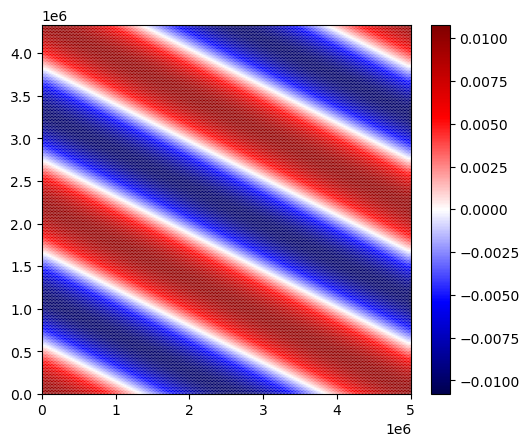

In [13]:
fig, ax, _ = heatMapMesh(mpasOcean, Array(mpasOceanCuda.sshCurrent))
display(fig)

the data copying step is actually 2 - 5 times slower than it is on the CPU! Memory is the bottleneck of the GPU